In [1]:
from functools import partial
import os, sys
import numpy as np
from numpy import log, exp, sqrt
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import *
from src.model import Environment, Agent

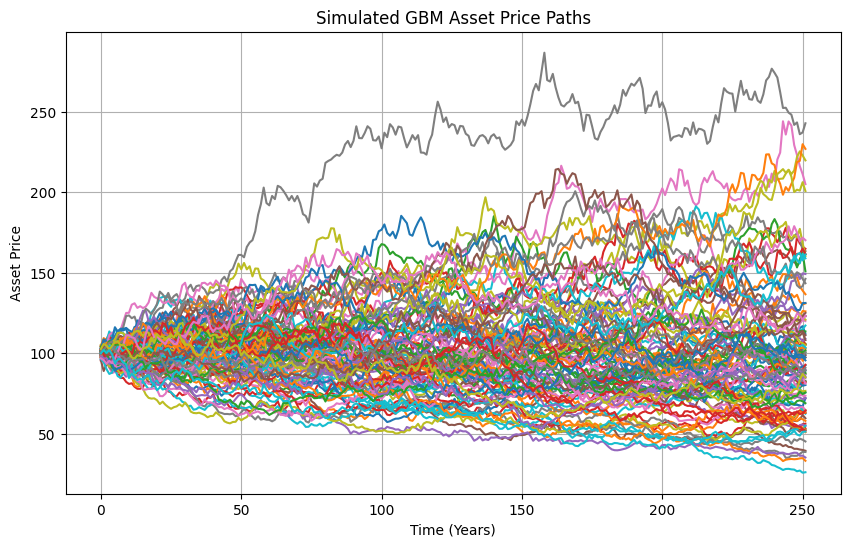

In [2]:
nsim = 100          
nstep = 252       
t1 = 0            
t2 = 1.0          
s_0 = 100        
r = 0.01         
q = 0.0          
v = 0.4          

price_paths = generate_gbm_paths(nsim, nstep, t1, t2, s_0, r, q, v)
#price_paths = generate_heston_paths(nsim, nstep, t1, t2, s_0, r, q, v, theta, rho, kappa, sigma, **kwargs)

plt.figure(figsize=(10, 6))
plt.plot(price_paths.T)
plt.title('Simulated GBM Asset Price Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()



In [3]:
K = 100 
price_paths = generate_gbm_paths(nsim=5000, nstep=252, t1=0, t2=1.0, s_0=100, r=0.04, q=0, v=0.4)
env = Environment(price_paths=price_paths, K=K, t1=0, t2=1.0, r=0.04, option_type="put")

obs = env.reset()
print(f"Initial Observation: {obs}")

done = False
step_count = 0

while not done:
    action = env.action_space.sample() 
    obs, reward, done, info = env.step(action)
    step_count += 1
    print(f"Step {step_count}: Obs={obs}, Reward={reward}, Done={done}, Info={info}")


Initial Observation: [99.56658    1.         0.9956658  0.       ]
Step 1: Obs=[99.56658    1.         0.9956658  0.       ], Reward=0.43341832825690574, Done=True, Info={'intrinsic_value': 0.43341832825690574}


In [4]:
agent = Agent(obssize=4, actsize=2, hidden_dim=128, depth=2, lr=1e-3, buffer_size=10000, batch_size=64, gamma=0.99, eps=1.0)
agent.initialize_buffer(env, steps=100000)  

In [5]:
def train(agent, env, episodes, update_target_every, moving_avg_window=50):
    """
    Train the agent and visualize training progress.
    """
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.buffer.add(state, action, reward, next_state, done)

            agent.learn()
            state = next_state
            total_reward += reward

        rewards.append(total_reward)

        # Update the target network periodically
        if episode % update_target_every == 0:
            agent.update_params()

        if episode % 5 == 0:
            print(f"Episode {episode}/{episodes}, Total Reward: {total_reward}, Average Reward: {np.mean(rewards)}, Eps: {agent.eps:.3f}")

            agent.eps = max(agent.eps * 0.99, 0.01)  # Eps decay 

    moving_avg_rewards = np.convolve(rewards, np.ones(moving_avg_window) / moving_avg_window, mode='valid')
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label="Total Reward per Episode", alpha=0.4)
    plt.plot(
        range(moving_avg_window - 1, len(rewards)),
        moving_avg_rewards,
        label=f"Moving Average Reward (window={moving_avg_window})",
        color='red'
    )
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress with Moving Average")
    plt.legend()
    plt.grid(True)
    plt.show()

    return rewards

/Users/GuidoDeFilippo/Columbia/Reinforcement Learning/orcs-4529-rl/notebooks/../src/model.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  return [torch.tensor(x, dtype=torch.float32) for x in zip(*batch)]


Episode 0/5000, Total Reward: 0.0, Average Reward: 0.0, Eps: 1.000
Episode 5/5000, Total Reward: 2.296430830384196, Average Reward: 1.5166990336946446, Eps: 0.990
Episode 10/5000, Total Reward: 0.7168594340549532, Average Reward: 0.9933504115009127, Eps: 0.980
Episode 15/5000, Total Reward: 1.3681172099358463, Average Reward: 1.4771623687324698, Eps: 0.970
Episode 20/5000, Total Reward: 5.960688354683708, Average Reward: 1.6204063138166518, Eps: 0.961
Episode 25/5000, Total Reward: 4.405245305935345, Average Reward: 1.683860620207096, Eps: 0.951
Episode 30/5000, Total Reward: 3.69630053795268, Average Reward: 1.8025169358585547, Eps: 0.941
Episode 35/5000, Total Reward: 0.0, Average Reward: 1.6316145549435708, Eps: 0.932
Episode 40/5000, Total Reward: 0.0, Average Reward: 1.6123720525405112, Eps: 0.923
Episode 45/5000, Total Reward: 1.217326106754257, Average Reward: 1.5893958402351795, Eps: 0.914
Episode 50/5000, Total Reward: 2.8418992537644243, Average Reward: 1.5613355375398101, Ep

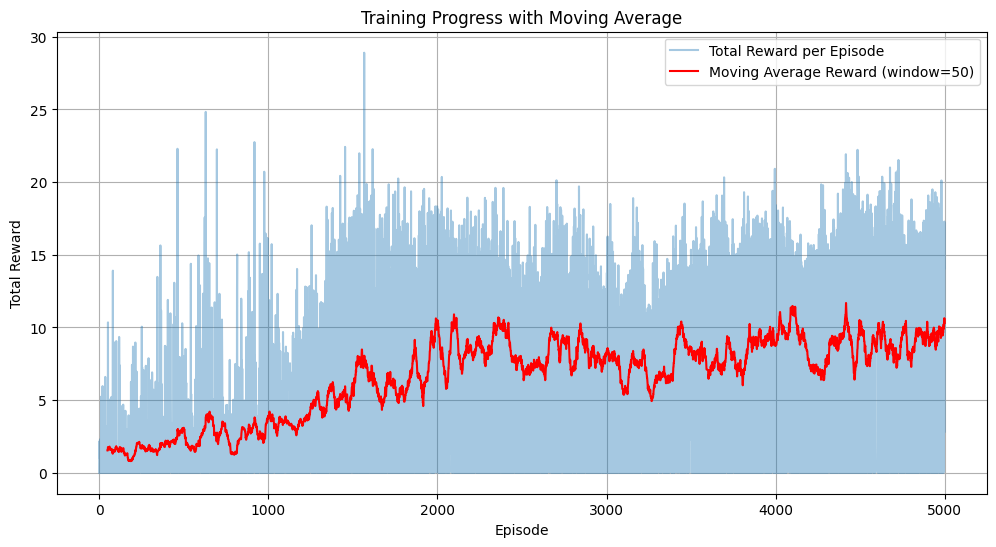

In [6]:
# Train the agent
episodes = 5000
update_target_every = 10
rewards = train(agent, env, episodes, update_target_every)

In [7]:
np.mean(rewards[4000:])

9.004212692756843

In [8]:
def plot_exercise_boundary(agent, env, n_paths=100, strike_price=150):
    """
    Visualize the early exercise boundary for a sample of paths.
    """
    plt.figure(figsize=(12, 8))
    exercise_points = []

    for i in range(n_paths):
        state = env.reset()
        path = [state[0]]  # Asset prices
        times = [0]  # Time steps
        done = False

        while not done:
            # Select an action using a greedy policy
            action = agent.act(state)

            if action == 1:  # Exercise
                exercise_points.append((env.current_step * env.dt, state[0]))  # Record exercise point
                done = True
            else:
                obs, _, done, _ = env.step(0) 
                state = obs  
                path.append(state[0]) 
                times.append(env.current_step * env.dt)

        # Plot the asset price path
        plt.plot(times, path, color='blue', alpha=0.3)

    # Plot exercise points if available
    if exercise_points:
        ex_times, ex_prices = zip(*exercise_points)
        plt.scatter(ex_times, ex_prices, color='red', label='Exercise Points')

    # Add strike price for reference
    plt.axhline(y=strike_price, color='green', linestyle='--', label='Strike Price')

    plt.title(f"Early Exercise Boundary Visualization ({n_paths} Paths)")
    plt.xlabel("Time (Years)")
    plt.ylabel("Asset Price")
    plt.legend()
    plt.grid(True)
    plt.show()

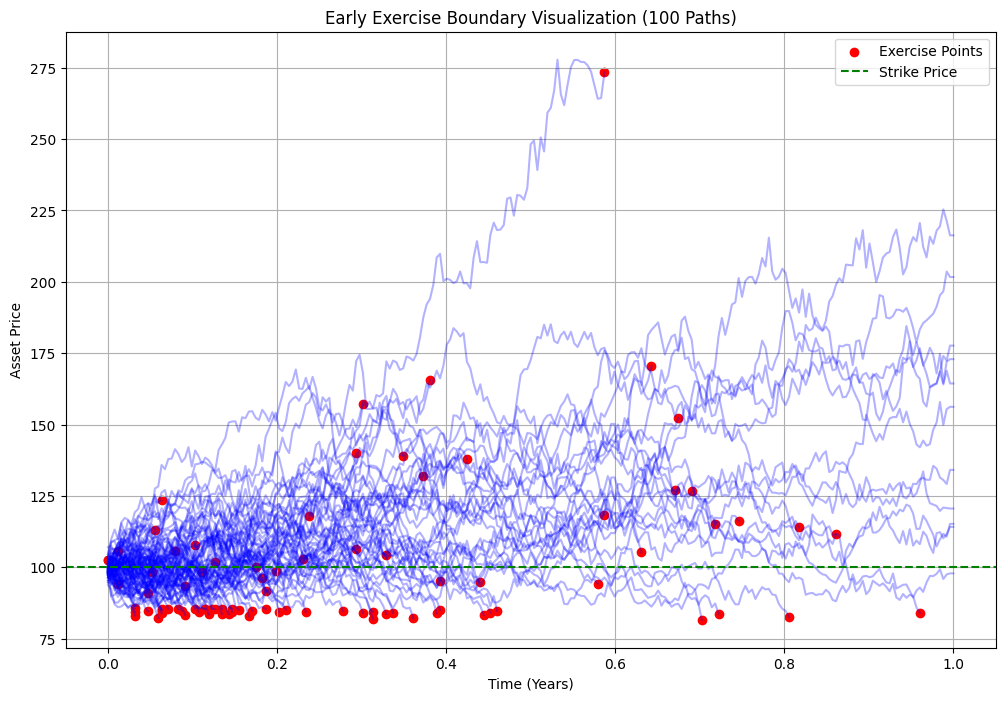

In [9]:
plot_exercise_boundary(agent, env, n_paths=100, strike_price=K)

In [10]:
def estimate_option_price(agent, env, n_paths=10000):
    """
    Estimate the option price using the trained agent.
    """
    total_rewards = []

    for _ in range(n_paths):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    # Return the average reward as the estimated price
    return np.mean(total_rewards)

In [11]:
estimate_option_price(agent, env, n_paths = 500)

8.779531480371467